In [1]:
from models import *
from util import *
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import time

In [2]:
ntfm = get_problem_features(['m4-tsfeatures.csv', 'm4-catch22features.csv'])
pdf = get_problem_algorithm_performance()

In [3]:
run=0
    
X_train, X_test, Y_train, Y_test = train_test_split(ntfm, pdf, test_size=0.2, random_state=run)
    
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=ntfm.columns)
X_test = pd.DataFrame(X_test, columns=ntfm.columns)
    
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, Y_train: {Y_train.shape}, Y_test: {Y_test.shape}')

X_train: (80000, 343), X_test: (20000, 343), Y_train: (80000, 61), Y_test: (20000, 61)


In [4]:
algorithm_name = 'sNaive'

y_train = Y_train[algorithm_name]
y_test = Y_test[algorithm_name]

In [5]:
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor

lin_regr = sklearn.neighbors.KNeighborsRegressor(n_jobs=-1)
lin_regr = MLPRegressor(hidden_layer_sizes=(100, 100))
#lin_regr = MLPRegressor()
#lin_regr = DummyRegressor(strategy="median")
lin_regr.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(100, 100))

In [6]:
def predict(X):
    algo_id = pdf.columns.to_list().index(algorithm_name)
    return lin_regr.predict(X)[:, algo_id]

In [7]:
print(mean_absolute_error(y_test, predict(X_test)))

0.066944478796837


In [8]:
kmeans_size = 20
X_train_summary = shap.kmeans(X_train, kmeans_size)

shap.initjs()

ex = shap.KernelExplainer(predict, X_train_summary)
shap_values = ex.shap_values(X_test.iloc[0,:])

#print(type(shap_values))
#shap_values = shap_values*ntfm.std()+ntfm.mean()

shap.force_plot(ex.expected_value, shap_values, X_test.iloc[0,:])

  0%|          | 0/1000 [00:00<?, ?it/s]

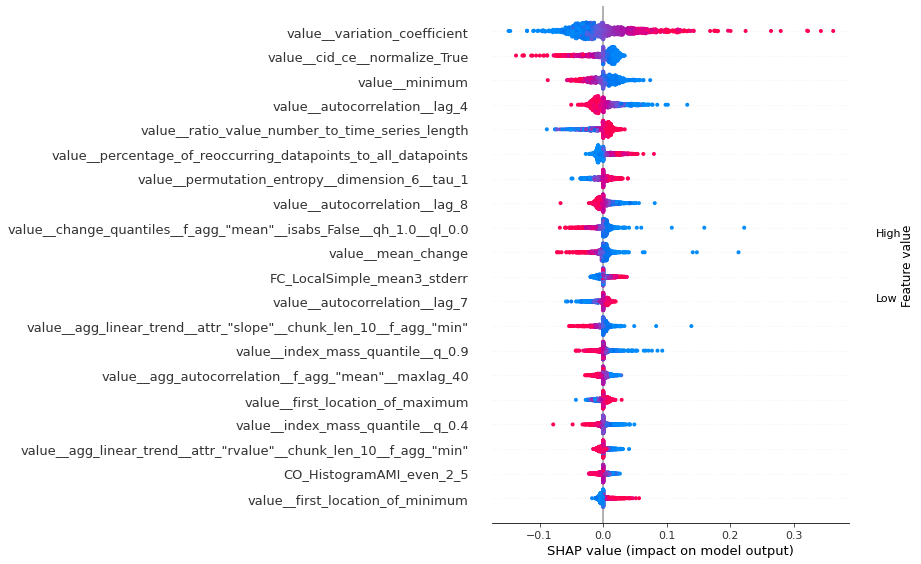

Execution time: 1386.6831381320953


In [9]:
start = time.time()

sample_size=1000
X_test_sample = X_test.sample(sample_size)

shap_values = ex.shap_values(X_test_sample)
shap.summary_plot(shap_values, X_test_sample)

end = time.time()
print("Execution time:", end-start)

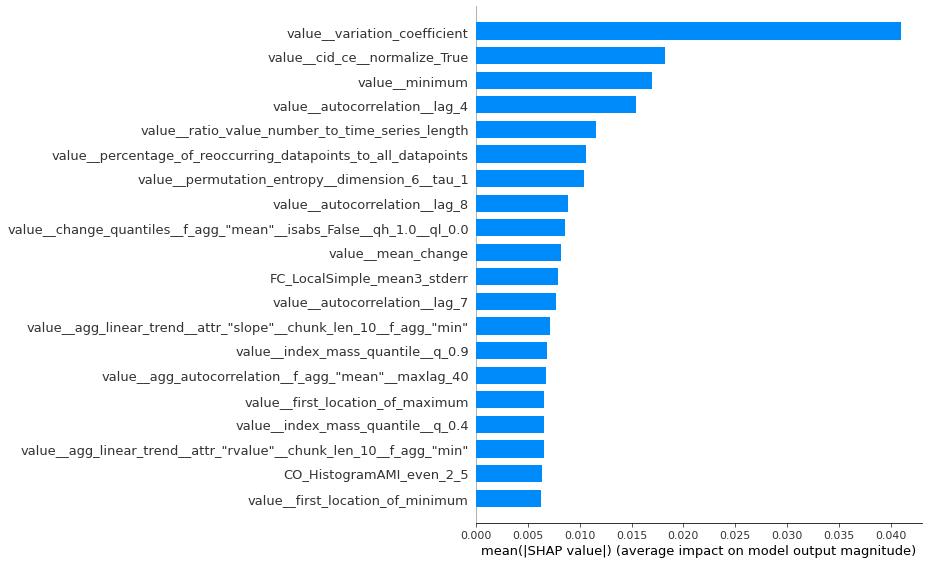

In [10]:
shap_values_new = shap_values
shap.summary_plot(shap_values_new, features=X_test, feature_names=X_test.columns, plot_type='bar')

In [11]:
vals = np.abs(shap_values).mean(0)
feature_names = X_train.columns

feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['name','importance'])
feature_importance.sort_values(by=['name'],
                               ascending=False, inplace=True)
feature_importance.head()

name  importance
12                     value__variation_coefficient    0.040963
13                                  value__variance    0.000175
36  value__time_reversal_asymmetry_statistic__lag_3    0.000177
35  value__time_reversal_asymmetry_statistic__lag_2    0.000188
34  value__time_reversal_asymmetry_statistic__lag_1    0.000189

In [12]:
Path('shap').mkdir(parents=True, exist_ok=True)

import pickle
pickle.dump(feature_importance['importance'].to_numpy(), open(f'shap/km_{kmeans_size}_ss_{sample_size}_algo_{algorithm_name}_run_{run}.p', 'wb'))

In [44]:
v = []
n = []
for f in glob.glob('shap/*'):
    vec = pickle.load(open(f, 'rb'))
    v.append(vec)
    n.append(f)

In [14]:
X = np.array(v)
X.shape

(9, 343)

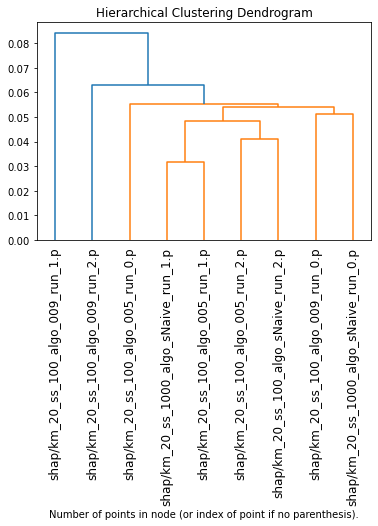

In [54]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix,  **kwargs)


#iris = load_iris()
#X = iris.data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='cosine', linkage='average')

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, labels=n)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.xticks(rotation=90)



plt.show()

In [17]:
#run=0

#X_train, X_test, Y_train, Y_test = train_test_split(ntfm, pdf, test_size=0.2, random_state=run)

#X_train_df = X_train.copy()

#X_train, X_test, Y_train, Y_test = X_train.to_numpy(), X_test.to_numpy(), Y_train.to_numpy(), Y_test.to_numpy()
#y_train = Y_train[:, 0]
#y_test = Y_test[:, 0]





#y_train = Y_train['005']
#y_test = Y_test['005']
    
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)
#
#X_train = pd.DataFrame(X_train, columns= ntfm.columns)
#X_test = pd.DataFrame(X_test, columns=ntfm.columns)
#Y_train = pd.DataFrame(Y_train, columns=pdf.columns)
#Y_test = pd.DataFrame(Y_test, columns=pdf.columns)
#
#y_train = Y_train['005']
#y_test = Y_test['005']

In [18]:
#X_train

In [19]:


# print the JS visualization code to the notebook
#shap.initjs()

In [20]:
#X,y = shap.datasets.adult()
#X_display,y_display = shap.datasets.adult(display=True)
#
## normalize data (this is important for model convergence)
#dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
#for k,dtype in dtypes:
#    if dtype == "float32":
#        X[k] -= X[k].mean()
#        X[k] /= X[k].std()
#
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)

In [21]:
# build model
#input_els = []
#encoded_els = []
#for k,dtype in dtypes:
#    input_els.append(Input(shape=(1,)))
#    if dtype == "int8":
#        e = Flatten()(Embedding(X_train[k].max()+1, 1)(input_els[-1]))
#    else:
#        e = input_els[-1]
#    encoded_els.append(e)
#encoded_els = concatenate(encoded_els)
#layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
#out = Dense(1)(layer1)

# train model
#model = Sequential()
#model.add(Dense(256, input_dim=X_train.shape[1], activation="relu"))
#model.add(Dropout(0.4))
#model.add(Dense(256, activation="relu"))
#model.add(Dropout(0.4))
#model.add(Dense(256, activation="relu"))
#model.add(Dropout(0.4))
#model.add(Dense(256, activation="relu"))
#model.add(Dense(1))

#regression = Model(inputs=input_els, outputs=[out])
#model.compile(optimizer="adam", loss='mae')
#model.fit(
#    X_train,
#    y_train,
#    epochs=50,
#    batch_size=512,
#    shuffle=True,
#    validation_data=(X_test, y_test)
#)

In [22]:
#def f(X):
#    return model.predict(X)

In [23]:
#explainer = shap.KernelExplainer(model, X_train[:50,:])
#shap_values = explainer.shap_values(X_test[299,:], nsamples=500)
#print(shap_values)
#shap.force_plot(explainer.expected_value, shap_values[0, :], X[299,:])

In [24]:
#X[299,:].shape
#np.array(X_train.head(20))

In [25]:
#explainer = shap.DeepExplainer(model, np.array(X_train.head(20)))

In [26]:
#shap_values = explainer.shap_values(np.array(X_train.head(20)))
#shap_values[0].shape

In [27]:
#shap.initjs()

#print(f'Current Label Shown: Precision \n')

#shap.summary_plot(shap_values = shap_values[0],
#                  features = X_train_df.iloc[:,:], max_display=10
#                  )

In [28]:
#shap.initjs()
#shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

In [29]:
#from models import *
#from util import *

In [30]:
#ntfm_tsfresh = get_problem_features()
#ntfm_catch22 = get_problem_features('m4-catch22features.csv')
#ntfm = ntfm_tsfresh.join(ntfm_catch22)
#
#pdf = get_problem_algorithm_performance()
#
#from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
#scaler = StandardScaler()
#
#X = ntfm.to_numpy()
#Y = pdf.to_numpy()
#
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=2001)
#
#y_train = Y_train[:, 0]
#y_test = Y_test[:, 0]
#
#
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [31]:
#print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

In [32]:
#model = KNNRegressorModel().load_model(f'models/trained/KNNRegressorModel_0')

In [33]:
#pred = model.predict(X_test)

In [34]:
#np.abs(pred-Y_test).mean()

In [35]:
#import shap
#
#from sklearn.preprocessing import StandardScaler
#from sklearn.neural_network import MLPRegressor
#from sklearn.pipeline import make_pipeline

In [36]:
#model = make_pipeline(
#    StandardScaler(),
#    MLPRegressor(hidden_layer_sizes=(50,), activation='logistic')
#)
#
#model.fit(X_train,y_train)

In [37]:
#explainer = shap.KernelExplainer(model.predict, X_train[:20, :])

#shap_values = explainer.shap_values(X_test[:10, :], nsamples=1, max_evals=700)
#shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test[0,:])
#shap.force_plot(explainer.expected_value[0], shap_values[0], X_test[0,:])

In [38]:
#shap.plots.bar(shap_values)

#X10 = shap.utils.sample(X_test, 10) # 100 instances for use as the background distribution

#explainer = shap.Explainer(model.predict, X10)
#shap_values = explainer(X10, max_evals=700)

In [39]:
#import numpy as np
#import matplotlib.pyplot as plt
#
## Fixing random state for reproducibility
#np.random.seed(19680801)
#
#mu, sigma = 100, 15
#x = mu + sigma * np.random.randn(10000)
#
## the histogram of the data
#n, bins, patches = plt.hist(pred.flatten(), 500, density=True, facecolor='g', alpha=0.75)
#
#
#plt.xlabel('Smarts')
#plt.ylabel('Probability')
#plt.title('Histogram of IQ')
#plt.grid(True)
#plt.show()

#shap_values

In [40]:
# compute the SHAP values for the linear model
#background = shap.maskers.Independent(X, max_samples=1000)
#explainer = shap.Explainer(model.predict, background)
#explainer = shap.TreeExplainer(model.predict)
#shap_values = explainer(X10, max_evals=700)

In [41]:
#explainer = shap.DeepExplainer(model.predict, X_train)
#shap_values = explainer.shap_values(X_test)

In [42]:
#background = shap.maskers.Independent(X, max_samples=1000)

#explainer = shap.KernelExplainer(model.predict, shap.sample(X_train, 100))
#shap_values = explainer.shap_values(X_test, nsamples=10)